# English project

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 33.6 MB/s 
     |████████████████████████████████| 197 kB 74.1 MB/s 
     |████████████████████████████████| 1.2 MB 64.8 MB/s 
     |████████████████████████████████| 60 kB 8.2 MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

## Downloading images

In [3]:
results = search_images_ddg('grizzly bear', max_images=150)
len(results), results[0]

(150,
 'https://i2.wp.com/braincharm.com/wp-content/uploads/2019/08/cropped-Grizzly-Bear-Bozeman-Grizzly-Montana-Bear-3483886.jpg?fit=960%2C540&ssl=1')

In [4]:
dest = 'images/bear.jpg'
download_url(results[0], dest)

Path('images/bear.jpg')

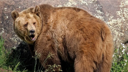

In [5]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [6]:
dog_types = 'grizzly', 'teddy', 'black'
path = Path('bears')

In [7]:
if not path.exists():
  path.mkdir()
  for o in dog_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o} bear', max_images=150)
    download_images(dest, urls=results)

In [8]:
fns = get_image_files(path)
fns

(#428) [Path('bears/grizzly/00000043.png'),Path('bears/grizzly/00000146.jpg'),Path('bears/grizzly/00000108.jpg'),Path('bears/grizzly/00000085.jpg'),Path('bears/grizzly/00000095.jpg'),Path('bears/grizzly/00000063.jpg'),Path('bears/grizzly/00000076.jpg'),Path('bears/grizzly/00000144.jpg'),Path('bears/grizzly/00000113.jpg'),Path('bears/grizzly/00000001.jpg')...]

In [9]:
failed = verify_images(fns)
failed

(#5) [Path('bears/grizzly/00000136.jpg'),Path('bears/grizzly/00000129.jpg'),Path('bears/teddy/00000047.png'),Path('bears/black/00000141.jpg'),Path('bears/black/00000064.jpg')]

In [10]:
failed.map(Path.unlink)

(#5) [None,None,None,None,None]

## From data to dataloaders

In [11]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [12]:
dls = bears.dataloaders(path)

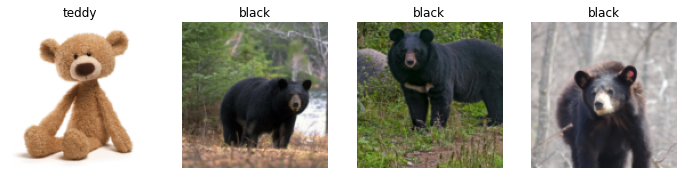

In [13]:
dls.valid.show_batch(max_n=4, nrows=1)

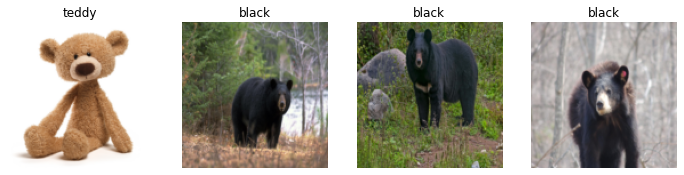

In [14]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

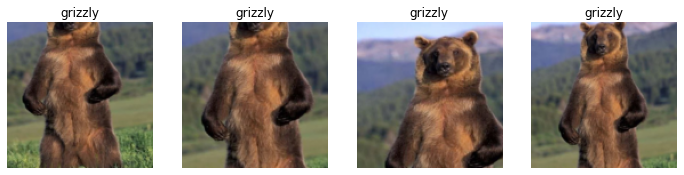

In [15]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Data augmentation

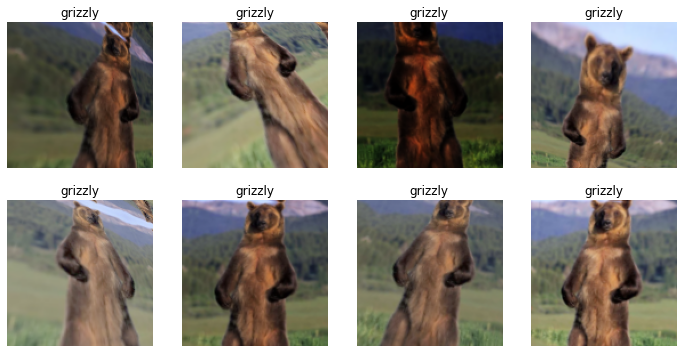

In [16]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training model

In [17]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [18]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.282597,0.218517,0.083333,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.168039,0.132162,0.023810,00:22
1,0.126000,0.146948,0.023810,00:24
2,0.094162,0.151641,0.023810,00:25
3,0.080853,0.140007,0.023810,00:23


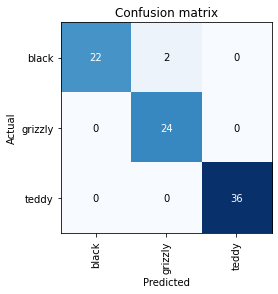

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

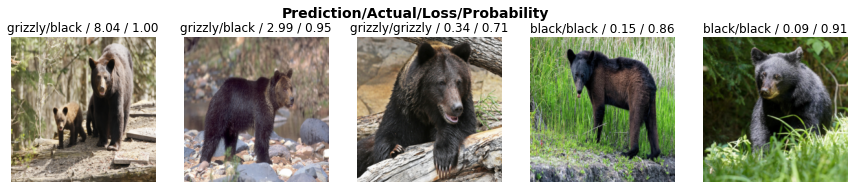

In [20]:
interp.plot_top_losses(5, nrows=1)

In [21]:
cleaner = ImageClassifierCleaner(learn)
cleaner

## Get pkt from first model

In [22]:
learn.export(fname='export.pkl')

In [23]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('first.pkl')]

In [24]:
learn_inf = load_learner(path/'export.pkl')

In [25]:
learn_inf.predict('images/bear.jpg')

('grizzly', TensorBase(1), TensorBase([7.9179e-06, 9.9999e-01, 4.7031e-07]))

In [26]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

## Widget

In [27]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [29]:
img = PILImage.create(btn_upload.data[-1])

In [30]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [31]:
pred,pred_idx,probs = learn_inf.predict(img)

In [32]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 1.0000')

In [33]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [34]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [35]:
btn_upload = widgets.FileUpload()

In [36]:
VBox([widgets.Label('Select your bear!'), btn_upload, btn_run, out_pl, lbl_pred])